In [71]:
# Importing required packages 
from qiskit import IBMQ, QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator, Statevector, state_fidelity
from qiskit.visualization import plot_state_qsphere, plot_histogram, plot_state_city
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua.algorithms import VQE
import numpy as np
import random, math
from scipy import optimize as opt
import matplotlib.pyplot as plt
from IPython.display import Image
import mitiq

provider = IBMQ.load_account()


ibmqfactory.load_account:WARNING:2020-12-17 22:00:24,799: Credentials are already in use. The existing account in the session will be replaced.


# Introduction 

Quantum computers provide a natural platform to perform simulations for the evolution of systems
Proposals of simulations of quantum field theories and experimental implementation (Zoller etc.) 
Klco et al. reducing the physical space and studying the discretized Schwinger model, proposal to study the noise restrictions they faced with the help of the mitiq package

## VQE of the ground state energy 

Through the use of physical symmetries within the system it is possible to restrict the matrix to the form 

\begin{equation}
H_{k=0,+}^{\lambda^2 = 3} =
\begin{pmatrix}
-2\mu & 2x & 0 & 0\\
2x & 1 & \sqrt{2}x & 0\\
0 & \sqrt{2}x & 2 + 2\mu & \sqrt{2}x \\
0 & 0 & \sqrt{2}x & 3 
\end{pmatrix}
\end{equation}

This 4x4 matrix can then be expressed in term of the polywords

\begin{equation}
\cal{O}_{i,j} = \frac{1}{4}\sigma_{i} \otimes \sigma_{j} 
\end{equation}
with $i,j = 0,1,2,3$ representing the Pauli matrices. Such that the hamiltonian is written as
\begin{equation}
H = \sum_{i,j} c_{i,j}\cal{O}_{i,j}
\end{equation} 
with each coefficient calculated as inner product of the matrices with the Hamiltonian (equivalent to finding the coefficients of real vector through the application of dot products) 

\begin{equation}
c_{i,j} = Tr( \cal{O}^{\dagger}H) = Tr( \cal{O}H) 
\end{equation}

which the following function will implement 

In [4]:
#Function to prepare the hamiltonian alognside the traceless one 
def Hamiltonian(mu,x):
    H = np.array([[-2*mu, 2*x, 0, 0],\
                  [2*x, 1, np.sqrt(2)*x, 0],\
                  [0, np.sqrt(2)*x, 2+2*mu, np.sqrt(2)*x],\
                  [0, 0, np.sqrt(2)*x, 3]])
    HT = H - (3/2)*np.eye(4)
    
    return H,HT



#Values used in the paper minimization
[H,HT] = Hamiltonian(0.1,0.6)


#Find the eigenvalues of the matrix to see if they 
#are the same 
eigenHT,_ = np.linalg.eig(HT);


In [50]:
eigenHT

array([-2.51163997, -0.39739922,  0.76804891,  2.14099028])

In [5]:
def decomposition_H(H):

    
    #Definition of the pauli matrices 
    sigma_0 = np.eye(2)
    sigma_X = np.array([[0,1],[1,0]])
    sigma_Y = np.array([[0,-1j],[1j,0]])
    sigma_Z = np.array([[1,0],[0,-1]])
    Pauli = [sigma_0,sigma_X,sigma_Y,sigma_Z]
    Pauli_name = ['I','X','Y','Z']
    
    #Creaiton of the pauli_words
    ii = 0 
    Poly = []
    Poly_name = []
    for i in Pauli:
        jj = 0
        for j in Pauli:
            Poly.append(np.kron(i,j))
            Poly_name.append(Pauli_name[ii] + Pauli_name[jj])
            jj += 1
        ii += 1

    
    #Doing the partial trace for the coefficinets 
    c = {}
    for i in range(len(Poly)):
        c[Poly_name[i]] = np.real(np.trace(np.matmul(Poly[i],H))/4)
        
    return c
    
coef = decomposition_H(HT)
#coef

Supposing we already have the decomposition then we can then express the expectation value of the energy of the hamiltonian as 

\begin{equation} 
    \left< H \right>_{\theta} = \sum_{i}c_{i} \big< \psi(\vec{\theta}) \big| \cal{O}_{i} \big| \psi(\vec{\theta})\big>
\end{equation}

where the initial state $\big| \psi(\vec{\theta})\big> $ is determined to an specific anzats created by the circuit in E10  

To properly implement in qiskit we use the RX,RY and RZ defined as 
 
\begin{align*} 
RX(\theta) &= e^{-i\theta\frac{\sigma_{X}}{2}} \\ 
RY(\theta) &= e^{-i\theta\frac{\sigma_{Y}}{2}} \\
RZ(\theta) &= e^{-i\theta\frac{\sigma_{Z}}{2}} \\ 
\end{align*}

The created circuit is such that 

\begin{equation}
    \big| \psi(\vec{\theta})\big> = U( \vec{\theta} ) \big| \vec{0} \big>
\end{equation}

In order to find the expected value it is usefu to consider a general qubit of the form 

\begin{equation}
    \big| \psi \big> = p_{00}\big| 00 \big> + p_{01}\big| 01 \big> + p_{10}\big| 10 \big> + p_{11}\big| 11 \big> 
\end{equation}

and consider the result of the expetation value of this state with a $\sigma_{Z} \otimes \sigma_{Z}$

\begin{split}
   \big< \psi \big| \sigma_{Z} \otimes \sigma_{Z} \big| \psi \big> &= \big< \psi \big| \sigma_{Z} \otimes \sigma_{Z} \Big(  p_{00}\big| 00 \big> + p_{01}\big| 01 \big> + p_{10}\big| 10 \big> + p_{11}\big| 11 \big> \Big) \\
   &=  \big< \psi \big| \Big(  p_{00}\big| 00 \big> - p_{01}\big| 01 \big> - p_{10}\big| 10 \big> + p_{11}\big| 11 \big>   \Big) \\
   &=  |p_{00}|^2 + |p_{11}|^2 - \big( |p_{10}|^2 + |p_{01}|^2  \big)
\end{split}

so in order to measure the expectation value from the results of an experiment, we just need to sum the counts with the formula above. For the case when the other pauli matrices appear there only needs to be a change in the basis of the measurements as 

\begin{align*}
\sigma_{X} &= (H)^{\dagger} \sigma_{Z} H \\
\sigma_{Y} &= (HS^{\dagger})^{\dagger} \sigma_{Z} HS^{\dagger}
\end{align*}



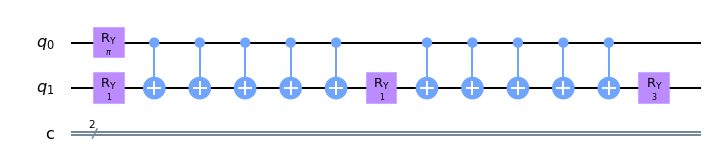

In [6]:
def State_Preparation(theta,r = 1):

    qc = QuantumCircuit(2,2)
    
    qc.ry(theta[1],0)
    qc.ry(theta[0],1)
    for i in range(2*r-1):
        qc.cnot(0,1)
    
    qc.ry(theta[0],1)
    for i in range(2*r-1):
        qc.cnot(0,1)
        
    qc.ry(theta[2],1)
    
    
    return qc

#Example circuit 
qc = State_Preparation([1,math.pi,3],r=2)
qc.draw('mpl')


We are using the qasm_simulator because it mimicks the behaviour of an actual device (https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html)

Give that we want to use mitiq to find 

In [82]:
def expectation_measurement(qc,coef,shots=1000,backend = 'qasm_simulator', noise = False):

    qc_state = qc.copy() #Save original state of quantum circuit
    i = 0 #keeping track of which state
    #Loop over possible gates
    list_circuit = []
    count = []
    exp = coef.copy()
    for key in coef.keys():
        qc_state = qc.copy() #Recover the original circuit
        if coef[key] == 0:   #Don't calculate expectation value if it doesn't have representaiton 
            continue  #Skip the coefficients we already know to be zero
            #pass     #Calculate expectation value for all combinations
        else:

                #Add pauli gates for different expectation values
            for q in range(2): #Lopp over two qubits
                if key[q] == 'I' or key[q] == 'Z':
                    pass
                elif key[q] == 'X':
                    qc_state.h(q)
                elif key[q] == 'Y':
                    qc_state.sdg(q)
                    qc_state.h(q)

                    
                    
            #Add measurement to the circut
            qc_state.measure([0,1], [0,1])
            
            
            if noise == False:
                #Run the circuit 
                
                job = execute(
                experiments=qc_state,
                #backend=provider.get_backend("machine name") to run on hardware
                backend=Aer.get_backend(backend),
                optimization_level=0, shots=shots
                )
                
            else:
                #Run the circuit
                #Note the order of the input tuple is coupling, basis and then noise
                
                job = execute(experiments = qc_state, backend = Aer.get_backend(backend),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model,
                 optimization_level=0, 
                 shots=shots
                 )
                
                

            #Extract the results counts 
            counts = job.result().get_counts()

            #Insert missing counts in case they're zero
            if '00' not in counts:
                counts['00'] = 0
            if '01' not in counts:
                counts['01'] = 0
            if '10' not in counts:
                counts['10'] = 0
            if '11' not in counts:
                counts['11'] = 0 

            if key[0] == 'I':
                if key[1] == 'I':
                    # Case + + + +
                    total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
                    exp_counts = total_counts
                    exp[key] = exp_counts/total_counts

                else: 
                    # Case + - + - 
                    total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
                    exp_counts = counts['00'] + counts['01'] - counts['10'] - counts['11']
                    exp[key] = exp_counts/total_counts
            else:
                if key[1] == 'I':
                    #Case + + - -
                    total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
                    exp_counts = counts['00'] - counts['01'] + counts['10'] - counts['11']
                    exp[key] = exp_counts/total_counts

                else:
                    #Case + - - +
                    total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
                    exp_counts = counts['00'] - counts['01'] - counts['10'] + counts['11']
                    exp[key] = exp_counts/total_counts

            list_circuit.append(qc_state)
            count.append(counts)
    return exp

qc = State_Preparation([6.19169047, 0.23821273, 5.29788566])
exp = expectation_measurement(qc,coef,noise = False)
print(exp)


{'II': 0.0, 'IX': -0.92, 'IY': 0.0, 'IZ': 0.372, 'XI': 0.0, 'XX': -0.188, 'XY': 0.0, 'XZ': 0.0, 'YI': 0.0, 'YX': 0.0, 'YY': -0.01, 'YZ': 0.0, 'ZI': 0.98, 'ZX': -0.876, 'ZY': 0.0, 'ZZ': 0.406}


Now we are in a position to construct the function to construct the function that gives the result of the expectation value 

In [22]:
def Expectation_Hamiltonian(theta,H,noise = False, r = 1,shots=1000,backend = 'qasm_simulator'):

    #Find the Pauli decomposition
    c = decomposition_H(H)
    
    #Define the wavefunction anzats 
    qc = State_Preparation(theta,r = r)
    
    #Expectation value for Pauli matrices
    exp = expectation_measurement(qc,c,shots,backend,noise = noise)
    
    #Expectation value of hamiltonian 
    H_exp = 0
    for key in c.keys():
        H_exp += c[key]*exp[key]       
    return H_exp

theta =[6.19169047, 0.23821273, 5.29788566]
Expectation_Hamiltonian(theta,H, noise = False)
    

-0.9739013418798095

We can construct now an optimization using COBYLA method that was found in the application process to be the most effecient one, as well as the recommended one inn the qiskit tutorial for VQE (https://qiskit.org/textbook/ch-applications/vqe-molecules.html). We will be using the scipy optimization package 




In [30]:
theta_0 = 2*math.pi*np.random.random([3]) #Initial random values
results = []
sol = opt.minimize(Expectation_Hamiltonian,theta_0,args=(HT),method='COBYLA',bounds=(0,2*math.pi), tol=1e-8)
results.append(sol.fun)

## Optimizing using zero noise extrapolation
The recipe for using zero noise extrapolation is to find the optimal theta for r = 1, and then use those values to find the expectation results using unitary folding in the CNOT gates (how it was done in the paper although mitqit has no cnot folding only which is strange)
Note that it is not the ideal way to do it, because you're using the r = 1 angles which might be noisy

In [66]:
## First find the optimal theta for r = 1

#Define type of model
noise = input_noise
#noise = False

#Array with values for different noise parameters
zne = [] 

#Obtain a solution with the standard circuit

sol = opt.minimize(Expectation_Hamiltonian,2*math.pi*np.random.random([3])
                   ,args=(HT,noise),method='COBYLA',tol=1e-8)

#Extract values of theta and expectation value
theta_zne = sol.x
zne.append(sol.fun)

# Finding expectation values for r = 3, 5 with previous theta
for r in range(2,6):
    zne.append(Expectation_Hamiltonian(theta_zne,HT,noise = noise, r = r))
    
# Extrapolate to r = 0 form previous n points 



In [74]:
#zne_simulation = zne
#zne_vigo = zne
#zne_melbourne = zne
#zne_santiago = zne
#zne_ibmqx2 = zne
zne_noextrap  = (zne_simulation,zne_vigo,zne_melbourne,zne_santiago,zne_ibmqx2)



```
#Graph results without extrapolation 
labels = [1,2,3,4,5]

plt.figure()
plt.plot(0,eigenHT[0],'ko')
plt.plot(labels,zne_simulation,'ro')
plt.plot(labels,zne_vigo,'bo')
plt.plot(labels,zne_melbourne,'go')
plt.plot(labels,zne_santiago,'co')
plt.plot(labels,zne_ibmqx2,'yo')
plt.gca().legend(('Exact','Simulation','Vigo','Melbourne','Santiago','Ibmqx2'))

_ =plt.savefig('zne without extrapolation.png')
plt.grid()

np.savetxt("zne_noextrap.csv",zne_noextrap, delimiter=",")
```

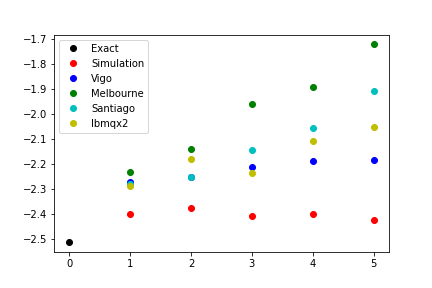

In [72]:
display(Image('zne without extrapolation.png'))

To use mitiq with just a few lines of code, we simply need to define a function which inputs a circuit and outputs the expectation value to mitigate. This function will:

Add measurement(s) to the circuit.

Run the circuit.

Convert from raw measurement statistics (or a different output format) to an expectation value.

We define this function in the following code block. Because we are using IBMQ backends, we first load our account.

## Running with Noise
We can see that the result of the VQE with a noiseless qasm simulator, we can try to add noise by running a simulation with the noise characteristics of a real quantum computer 

In [65]:
#Select machine to imitate the noise

machine = 'ibmq_vigo'
#machine = 'ibmq_16_melbourne'
#machine = 'ibmq_santiago'
#machine = 'ibmqx2'

backend = provider.get_backend(machine)
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

input_noise = (coupling_map,basis_gates,noise_model)


([[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]], ['cx', 'id', 'u2', 'u3'], NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'id', 'u3', 'cx', 'u2']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [3, 1]), ('cx', [1, 3]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [0, 1]), ('cx', [1, 0]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])])


In [38]:
theta_0 = 2*math.pi*np.random.random([3]) #Initial random values

sol = opt.minimize(Expectation_Hamiltonian,theta_0,args=(HT,input_noise),method='COBYLA',bounds=(0,2*math.pi))
print(sol.fun)
results.append(sol.fun)

-2.0848185709548344


In [37]:
results_noise = [-2.511639972107E+00,
-2.458433722856E+00,
-2.165740952187E+00,
-2.219961298297E+00,
-2.274047099602E+00,
-2.084818570955E+00,
]

error_noise = []
for i in range(len(results_noise)):
    error_noise.append(abs(results_noise[i]-results_noise[0])*100/abs(results_noise[0]))

Text(0, 0.5, 'Error Percentage')

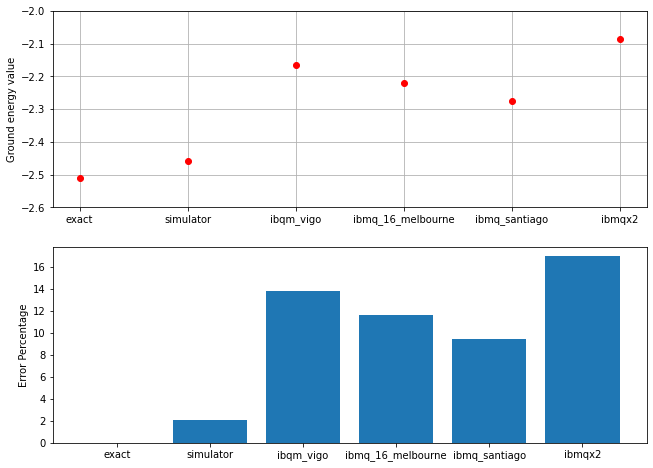

In [40]:
labels = ['exact','simulator','ibqm_vigo','ibmq_16_melbourne','ibmq_santiago','ibmqx2']

plt.figure(1)

plt.subplot(2,1,1)
plt.plot(labels,results_noise,'ro')
plt.gcf().subplots_adjust(right = 1.5,top = 1.5,bottom = 0)
plt.grid()
plt.ylim([-2.6,-2])
plt.ylabel('Ground energy value')


plt.subplot(2,1,2)
plt.bar(labels,error_noise)
plt.ylabel('Error Percentage')


## Using the mitiq platform 

Let's try to do some folding test with the trial circuit 

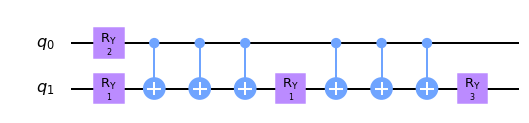

In [79]:
qc = State_Preparation([1,2,3])

#folded = fold_gates_from_left(qc, scale_factor=2)
#folded = fold_gates_from_right(qc, scale_factor=4,fidelities={"single": 1.0,"CNOT": 0.99})
folded = fold_gates_at_random(qc, scale_factor=3,fidelities={"single": 1.0,"CNOT": 0.99})
#folded = fold_global(qc, scale_factor=3,fidelities={"single": 1.0,"CNOT": 0.99})
folded.draw('mpl')

In [ ]:
import cirq
from mitiq.zne.scaling import converter

@converter
def my_custom_folding_function(circuit: cirq.Circuit, scale_factor: float) -> cirq.Circuit:
    # Insert custom folding method here
    return folded_circuit

    

In [93]:
from functools import partial

def executor(qc, coef, noise = False) -> float:
    exp = expectation_measurement(qc,coef)
    result = exp['IX']
    return result

new_executor = partial(
    executor,
    coef = coef
)

#result = new_executor(qc)
mitigated = mitiq.execute_with_zne(qc,new_executor)



CircuitError: 'Index out of range.'

We seem to be having troubles trying to get the zne from mitqit to run so we will modify the expectation_function as to not modify the circuit structure for several deep copies (could that be the issue?), maybe the fact that we modify the circuit inside the executor 

In [ ]:
def zne_State_Preparation(theta,)